# 7UP XGBoost Model Evaluation

Import same libraries as before.

In [2]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

# %pip install pandas
# %pip install xgboost
# %pip install kmodes

## Note: install graphviz in terminal with the following command
#brew install graphviz

## For the python interface and wrapper for graphviz
# %pip install graphviz

In [3]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

Import datafile

In [4]:
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

df = pd.read_csv(filepath)
df2 = df.copy()

In [5]:
def preprocess(data: pd.DataFrame):

    ## One-hot encoding
    data = pd.get_dummies(data, columns=['Entity Type'], prefix = 'Entity Type')
    data = pd.get_dummies(data, columns=['Parent Country'], prefix='Parent Country')

    ## SIC Code handling

    # Find the frequency of each industry
    sic_code_frequency = df['SIC Code'].value_counts()
    # Note, use original df here so the same list of SIC codes are used as in the xgboost model.

    # Set a threshold for low-frequency SIC Codes
    threshold = 7  # Adjust this threshold based on your preference

    # Identify SIC Codes with frequency below the threshold
    low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index

    # Replace these low-frequency SIC Codes with a common label "Others"
    data['SIC Code'] = data['SIC Code'].replace(low_frequency_sic_codes, 'Others')

    sic_code_frequency1 = data['SIC Code'].value_counts()

    # Convert SIC Code to a 'category' data type so that it can be read by xgboost
    data['SIC Code'] = data['SIC Code'].astype('category')

    ## Column removal
    columns_to_remove = ["AccountID", "Company", "8-Digit SIC Code", "8-Digit SIC Description", "Industry", "Company Description", "Company Status (Active/Inactive)", "Ownership Type", "Square Footage", "Parent Company", "Domestic Ultimate Company", "Global Ultimate Company", "Year Found", "Fiscal Year End", "Employees (Single Site)", "Employees (Global Ultimate Total)", "Import/Export Status", "Global Ultimate Country", "Is Global Ultimate"]
    data = data.drop(columns=columns_to_remove)

    ## Latitude or Longitude NA value handling

    # Remove rows without either Latitude or Longitude coordinates
    data = data.dropna(subset=["LATITUDE", "LONGITUDE"])
    data = data.dropna(subset=["Employees (Domestic Ultimate Total)"])

    return data

Restore data to just before we built the model.

In [6]:
df = preprocess(df)

Analyse processed data, these are all the attributes our XGBoost model had evaluated.

In [7]:
feature_names = df.columns
print(feature_names)

Index(['LATITUDE', 'LONGITUDE', 'SIC Code',
       'Employees (Domestic Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Is Domestic Ultimate',
       'Entity Type_Branch', 'Entity Type_Independent', 'Entity Type_Parent',
       'Entity Type_Subsidiary', 'Parent Country_Antigua and Barbuda',
       'Parent Country_Australia', 'Parent Country_Austria',
       'Parent Country_Bahamas', 'Parent Country_Bahrain',
       'Parent Country_Bangladesh', 'Parent Country_Belgium',
       'Parent Country_Belize', 'Parent Country_Bermuda',
       'Parent Country_Brunei Darussalam', 'Parent Country_Canada',
       'Parent Country_Cayman Islands', 'Parent Country_Chile',
       'Parent Country_China', 'Parent Country_Cook Islands',
       'Parent Country_Curacao', 'Parent Country_Cyprus',
       'Parent Country_Denmark', 'Parent Country_Estonia',
       'Parent Country_Finland', 'Parent Country_France',
       'Parent Country_Germany', 'Pare

In [8]:
df.describe()

,LATITUDE,LONGITUDE,Employees (Domestic Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate
count,28984.000000,28984.000000,28984.000000,2.898400e+04,2.898400e+04,28984.000000
mean,1.320661,103.843306,139.913159,7.550668e+08,3.933387e+09,0.500207
std,0.043747,0.053737,1120.835032,1.022798e+10,2.185055e+10,0.500009
min,1.238792,103.611319,1.000000,-1.502631e+08,1.000000e+00,0.000000
25%,1.284665,103.831822,4.000000,1.026308e+06,1.026308e+06,0.000000
50%,1.309643,103.848989,16.000000,2.584560e+06,3.193644e+06,1.000000
75%,1.337883,103.865666,60.000000,2.165912e+07,1.480732e+08,1.000000
max,1.469800,104.003218,80000.000000,3.184764e+11,5.140000e+11,1.000000


In [9]:
df.head()

,LATITUDE,LONGITUDE,SIC Code,Employees (Domestic Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate,Entity Type_Branch,Entity Type_Independent,Entity Type_Parent,...,Parent Country_Sweden,Parent Country_Switzerland,Parent Country_Taiwan,Parent Country_Thailand,Parent Country_Turkey,Parent Country_United Arab Emirates,Parent Country_United Kingdom,Parent Country_United States,Parent Country_Vietnam,Parent Country_Virgin Islands (British)
0,1.285495,103.843852,7361.0,25.0,2.209224e+06,4.637871e+06,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.291294,103.827476,4449.0,100.0,7.093536e+09,7.093536e+09,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.300144,103.857517,6719.0,4.0,1.026308e+06,1.026308e+06,1.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.300785,103.791263,6719.0,100.0,7.339898e+10,7.339898e+10,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.298759,103.859430,6719.0,4.0,4.322130e+05,4.322130e+05,1.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Load the model

In [10]:
from xgboost import XGBRegressor

def load_model():
    # Load the model
    loaded_model = XGBRegressor()
    loaded_model.load_model('7UP_xgboost_model.json')
    return loaded_model

# Reconstruct the XGBoost model from the JSON
# We need to create a Booster object and load the model from JSON
model = load_model()

Visualise top 10 most important features

<Figure size 1000x2000 with 0 Axes>

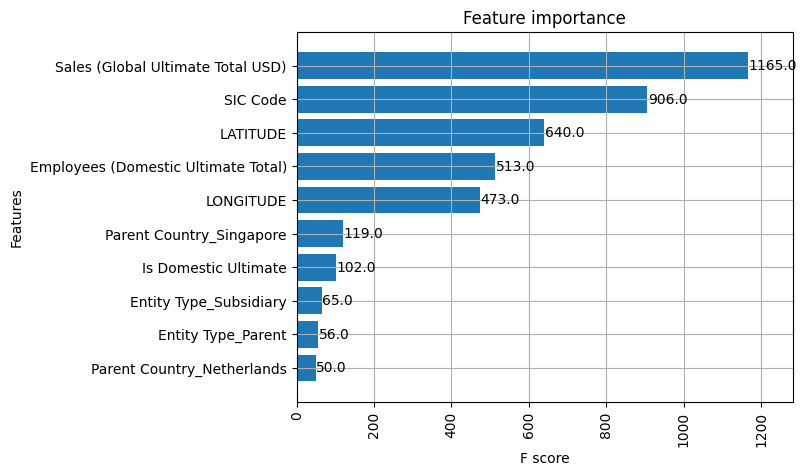

In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming 'model' is your trained XGBoost model

# Increase figure size
plt.figure(figsize=(10, 20))  # Adjust the dimensions as needed

# Plot feature importance
# Use max_num_features to limit the number of features displayed
xgb.plot_importance(model, max_num_features=10, importance_type='weight', height=0.8)

# Rotate feature names
plt.xticks(rotation=90)

# Adjust font size
plt.rc('xtick', labelsize=8)  # Adjust font size as needed

plt.show()

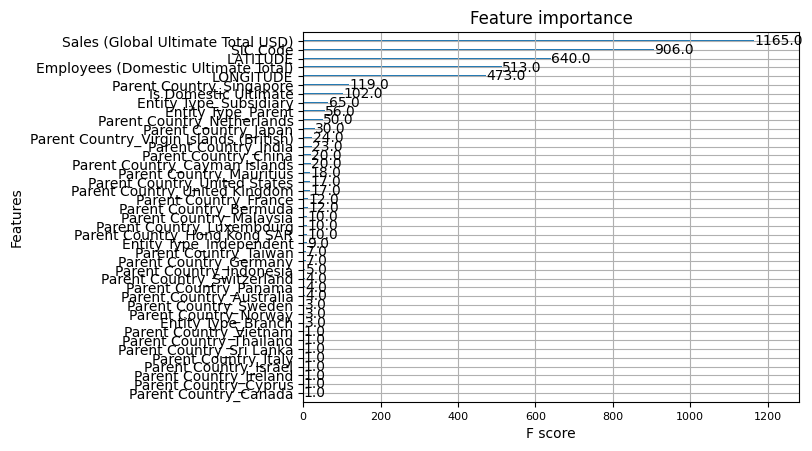

In [12]:
# To plot all 41 features:
xgb.plot_importance(model, max_num_features=41)
plt.show()

In [13]:
booster = model.get_booster()
graph = xgb.to_graphviz(booster, num_trees=1)
graph.render('tree', format='pdf')  # Saves the tree as a PNG file

'tree.pdf'

In [14]:
import xgboost as xgb

# Assuming 'model' is your trained XGBoost model
booster = model.get_booster()
# Export the first tree to DOT format
dot_tree = xgb.to_graphviz(booster, num_trees=0) #, rankdir='LR')

# Save the DOT data to a file
#dot_tree.render(filename='tree', format='dot')


'tree.dot'

In [21]:
# Assuming 'model' is your trained XGBoost model
booster = model.get_booster()
num_trees = len(booster.get_dump())
print(f"The total number of trees in the model is: {num_trees}")

total_nodes = sum(len(tree.get_dump()) for tree in model.get_booster())
print(f"The total number of nodes in the model is: {total_nodes}")

# Dump model with stats
model_dump = booster.get_dump(with_stats=True)

# Function to find maximum depth of a tree
def find_tree_depth(tree_dump):
    max_depth = 0
    for line in tree_dump.split('\n'):
        if 'depth=' in line:
            # Extract depth information
            depth = int(line.split('depth=')[1].split(',')[0])
            max_depth = max(max_depth, depth)
    return max_depth

# Find depth of each tree and print it
tree_depths = [find_tree_depth(tree) for tree in model_dump]
# for tree_index, depth in enumerate(tree_depths):
#     print(f"Tree {tree_index} depth: {depth}")

# Find the maximum depth across all trees
max_depth_overall = max(tree_depths)
print(f"The maximum depth among all trees is: {max_depth_overall}")

The total number of trees in the model is: 50
The total number of nodes in the model is: 50
The maximum depth among all trees is: 0


In [24]:
tree_df = model.get_booster().trees_to_dataframe()
tree_df.head()

ValueError: Failed to parse model text dump.

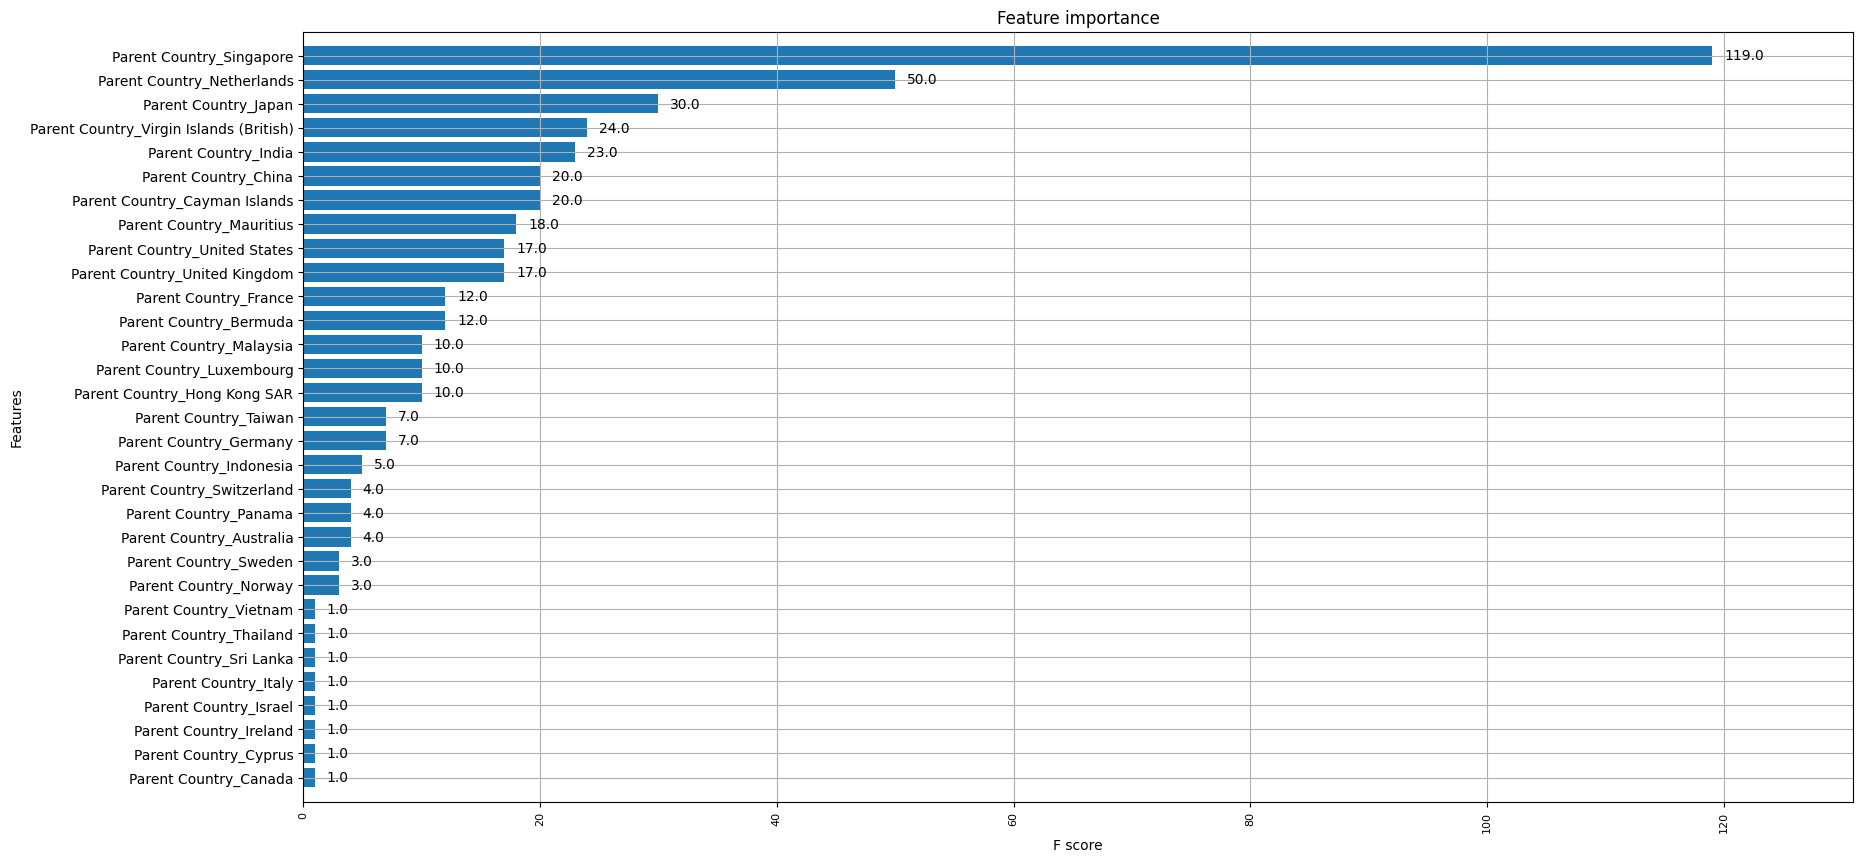

In [28]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming 'model' is your trained XGBoost model
# Get the feature importances from the model
f_importances = model.get_booster().get_score(importance_type='weight')

# Filter the dictionary to only include features starting with 'Parent Company'
f_importances_filtered = {k: v for k, v in f_importances.items() if k.startswith('Parent Country')}

# Now, plot the filtered feature importances
plt.figure(figsize=(20, 10))  # Adjust the dimensions as needed
ax = plt.gca()  # Get current axis for the plot

# Plot the feature importances
xgb.plot_importance(f_importances_filtered, ax=ax, max_num_features=31, height=0.8)

# Rotate feature names
plt.xticks(rotation=90)

# Adjust font size
plt.rc('xtick', labelsize=8)  # Adjust font size as needed

# Save the plot to a PNG file
#plt.savefig('feature_importance.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [18]:
print(df2.columns)

Index(['LATITUDE', 'LONGITUDE', 'AccountID', 'Company', 'SIC Code', 'Industry',
       '8-Digit SIC Code', '8-Digit SIC Description', 'Year Found',
       'Entity Type', 'Parent Company', 'Parent Country', 'Ownership Type',
       'Company Description', 'Square Footage',
       'Company Status (Active/Inactive)', 'Employees (Single Site)',
       'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Import/Export Status',
       'Fiscal Year End', 'Global Ultimate Company', 'Global Ultimate Country',
       'Domestic Ultimate Company', 'Is Domestic Ultimate',
       'Is Global Ultimate'],
      dtype='object')


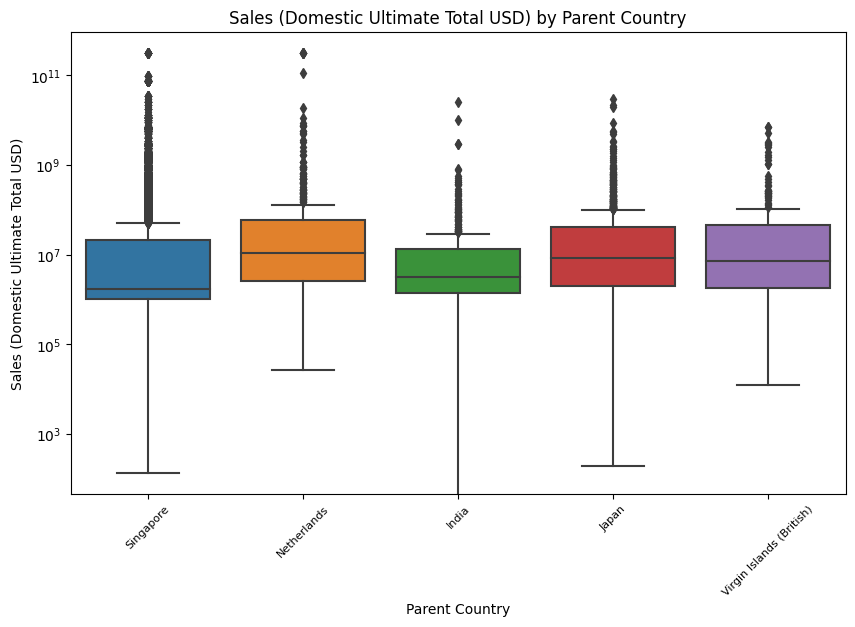

In [25]:
# Assuming 'df' is your DataFrame and it's already loaded in the environment
# For demonstration, let's create a sample DataFrame
# Sample DataFrame creation would be skipped in actual execution if 'df' is already provided

# Sample data creation (to be commented out or removed in actual use case)
countries = ['Singapore', 'Netherlands', 'Japan', 'Virgin Islands (British)', 'India']

# Filter the DataFrame for the specified countries
countries_of_interest = ["Singapore", "Netherlands", "Japan", "Virgin Islands (British)", "India"]
filtered_df = df2[df2['Parent Country'].isin(countries_of_interest)]

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=filtered_df, x='Parent Country', y='Sales (Domestic Ultimate Total USD)')
ax.set_yscale('log')  # Set the y-axis to a logarithmic scale
plt.title('Sales (Domestic Ultimate Total USD) by Parent Country')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

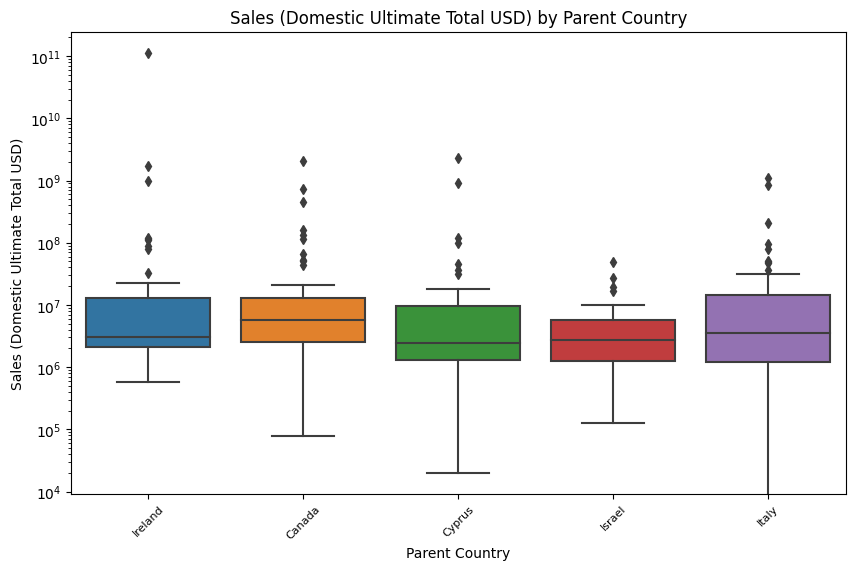

In [32]:
# Look at bottom 5 countries by feature importance

# Sample data creation (to be commented out or removed in actual use case)
countries = ['Singapore', 'Netherlands', 'Japan', 'Virgin Islands (British)', 'India']

# Filter the DataFrame for the specified countries
countries_of_interest = ["Canada", "Cyprus", "Ireland", "Israel", "Italy"]
filtered_df = df2[df2['Parent Country'].isin(countries_of_interest)]

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=filtered_df, x='Parent Country', y='Sales (Domestic Ultimate Total USD)')
ax.set_yscale('log')  # Set the y-axis to a logarithmic scale
plt.title('Sales (Domestic Ultimate Total USD) by Parent Country')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()